In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
from scipy.stats import pearsonr, spearmanr
from ta import add_all_ta_features
from ta.utils import dropna
from sklearn.preprocessing import MinMaxScaler

def analyze_technical_correlations(ticker):
    # Step 1: Download stock data
    print(f"📥 Downloading data for {ticker}...")
    end_date = datetime.today()
    start_date = end_date - relativedelta(years=10)

    df = yf.download(ticker, start=start_date, end=end_date, interval="1d", auto_adjust=True)
    if df.empty:
        print(f"❌ No data retrieved for {ticker}.")
        return

    df.reset_index(inplace=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Step 2: Add all TA-lib indicators
    print("🧠 Computing all technical indicators...")
    df = dropna(df)
    df = add_all_ta_features(df,
                             open="Open", high="High", low="Low",
                             close="Close", volume="Volume",
                             fillna=True)

    df.reset_index(inplace=True)
    
    # Step 3: Normalize data
    print("📊 Normalizing numeric features...")
    df['Returns'] = df['Close'].pct_change()
    df['Lagged_Returns'] = df['Returns'].shift(1)
    df.dropna(inplace=True)

    scaler = MinMaxScaler()
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    # Step 4: Select indicator columns (exclude target variables)
    exclude_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'Lagged_Returns']
    indicator_cols = [col for col in df.columns if col not in exclude_cols]

    # Step 5: Correlation Analysis
    print("🔍 Calculating correlations...")
    pearson_results = {'Price': {}, 'Returns': {}, 'Lagged_Returns': {}}
    spearman_results = {'Price': {}, 'Returns': {}, 'Lagged_Returns': {}}

    def calculate_correlations(data, x_col, y_col, lag=0):
        x = data[x_col].shift(lag) if lag > 0 else data[x_col]
        y = data[y_col]
        valid_data = pd.concat([x, y], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
        if len(valid_data) < 3:
            return np.nan, np.nan
        try:
            p_corr, _ = pearsonr(valid_data.iloc[:, 0], valid_data.iloc[:, 1])
            s_corr, _ = spearmanr(valid_data.iloc[:, 0], valid_data.iloc[:, 1])
            return p_corr, s_corr
        except:
            return np.nan, np.nan

    for col in indicator_cols:
        for label, y_col, lag in [('Price', 'Close', 0), ('Returns', 'Returns', 0), ('Lagged_Returns', 'Returns', 1)]:
            p_corr, s_corr = calculate_correlations(df, col, y_col, lag)
            pearson_results[label][col] = p_corr
            spearman_results[label][col] = s_corr

    pearson_df = pd.DataFrame(pearson_results)
    spearman_df = pd.DataFrame(spearman_results)

    # Step 6: Save correlation data
    # pearson_df.to_csv(f"{ticker}_pearson_correlations.csv")
    # spearman_df.to_csv(f"{ticker}_spearman_correlations.csv")

    # # Step 7: Visualize with heatmaps
    # print("📈 Creating heatmaps...")
    # plt.figure(figsize=(14, 10))
    # sns.heatmap(pearson_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    # plt.title(f"{ticker} - Pearson Correlation Heatmap")
    # plt.tight_layout()
    # plt.savefig(f"{ticker}_pearson_heatmap.png")
    # plt.show()

    # plt.figure(figsize=(14, 10))
    # sns.heatmap(spearman_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    # plt.title(f"{ticker} - Spearman Correlation Heatmap")
    # plt.tight_layout()
    # plt.savefig(f"{ticker}_spearman_heatmap.png")
    # plt.show()

    # Step 8: Show strong correlations
    print("\n📌 Significant Pearson Correlations (|corr| > 0.7):")
    print(pearson_df[(pearson_df['Price'].abs() > 0.7)])
    # store them in a file 
    pearson_df[(pearson_df['Price'].abs() > 0.7)].to_csv(f"Pearsons_Coeff/{ticker}_significant_pearson.csv")

    print("\n📌 Significant Spearman Correlations (|corr| > 0.7):")
    print(spearman_df[(spearman_df['Returns'].abs() > 0.7)])



    # def plot_significant_indicators(df, indicator_list):
    #     print("\n📉 Plotting significant indicators with Close price...")
    #     df_plot = df.set_index('Date')
    #     for indicator in indicator_list:
    #         if indicator not in df_plot.columns:
    #             continue
    #         plt.figure(figsize=(14, 6))
    #         plt.plot(df_plot['Close'], label='Close Price', linewidth=2)
    #         plt.plot(df_plot[indicator], label=indicator, linestyle='--')
    #         plt.title(f"{ticker} - Close vs {indicator}")
    #         plt.xlabel("Date")
    #         plt.ylabel("Normalized Value")
    #         plt.legend()
    #         plt.tight_layout()
    #         # plt.savefig(f"{ticker}_Close_vs_{indicator}.png")
    #         plt.show()

    # significant_indicators = pearson_df.index[pearson_df['Price'].abs() > 0.7].tolist()
    # plot_significant_indicators(df, significant_indicators)


In [5]:
# analyze_technical_correlations("TCS.NS")  #Large Cap IT
# analyze_technical_correlations("INFY.NS") #large Cap IT
# analyze_technical_correlations("WIPRO.NS")  #Large Cap IT
# analyze_technical_correlations("HCLTECH.NS") # Large Cap IT
# Mid Cap IT
# analyze_technical_correlations("TECHM.NS")  # Mid Cap IT
analyze_technical_correlations("PERSISTENT.NS")  # Mid Cap IT
# Small Cap IT
analyze_technical_correlations("LTIM.NS")  # Small Cap IT


📥 Downloading data for PERSISTENT.NS...


[*********************100%***********************]  1 of 1 completed
/Users/utsavdhanuka/miniconda3/envs/env_pytorch/lib/python3.9/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


🧠 Computing all technical indicators...
📊 Normalizing numeric features...
🔍 Calculating correlations...

📌 Significant Pearson Correlations (|corr| > 0.7):
                            Price   Returns  Lagged_Returns
volume_obv               0.913873  0.032441        0.024162
volume_vpt               0.933724  0.028945        0.017329
volume_vwap              0.998582  0.008489        0.006217
volatility_bbm           0.997580  0.007176        0.006108
volatility_bbh           0.997311  0.008696        0.007447
volatility_bbl           0.995730  0.005412        0.004553
volatility_kcc           0.998796  0.007942        0.006429
volatility_kch           0.998656  0.008059        0.006448
volatility_kcl           0.998798  0.007817        0.006407
volatility_dcl           0.996313  0.007298        0.004764
volatility_dch           0.997593  0.010424        0.007111
volatility_dcm           0.997770  0.008990        0.006034
volatility_atr           0.946409  0.011932        0.007352
tren

[*********************100%***********************]  1 of 1 completed
/Users/utsavdhanuka/miniconda3/envs/env_pytorch/lib/python3.9/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


🧠 Computing all technical indicators...
📊 Normalizing numeric features...
🔍 Calculating correlations...

📌 Significant Pearson Correlations (|corr| > 0.7):
                            Price   Returns  Lagged_Returns
volume_adi               0.804057  0.008795       -0.036834
volume_obv               0.972377 -0.021606       -0.035083
volume_vpt               0.973217 -0.023971       -0.035908
volume_vwap              0.997035 -0.037614       -0.042542
volume_nvi              -0.868729  0.022731        0.014547
volatility_bbm           0.994679 -0.040832       -0.043124
volatility_bbh           0.991501 -0.041910       -0.044406
volatility_bbl           0.993506 -0.039391       -0.041437
volatility_kcc           0.997448 -0.038726       -0.041770
volatility_kch           0.997211 -0.038914       -0.042012
volatility_kcl           0.997398 -0.038517       -0.041502
volatility_dcl           0.994454 -0.036195       -0.041411
volatility_dch           0.992637 -0.037111       -0.043896
vola

SENSITIVITY ANALYSIS

In [1]:
def sensitivity_analysis(ticker, period=1):
    import pandas as pd
    import numpy as np
    import yfinance as yf
    import matplotlib.pyplot as plt
    from ta import add_all_ta_features
    from ta.utils import dropna
    from datetime import datetime
    from dateutil.relativedelta import relativedelta
    from scipy.stats import zscore

    print(f"📥 Downloading data for {ticker}...")
    end_date = datetime.today()
    start_date = end_date - relativedelta(years=10)

    df = yf.download(ticker, start=start_date, end=end_date, interval="1d", auto_adjust=True)
    if df.empty:
        print(f"❌ No data retrieved for {ticker}.")
        return

    df.reset_index(inplace=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Step 2: Add technical indicators
    print("🧠 Computing all technical indicators...")
    df = dropna(df)
    df = add_all_ta_features(df,
                             open="Open", high="High", low="Low",
                             close="Close", volume="Volume",
                             fillna=True)
    df.reset_index(inplace=True)

    # Z-score normalization for numeric columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].apply(zscore)
    df.dropna(inplace=True)

    # Calculate price change
    df['Price_Change'] = df['Close'].diff(periods=period)
    df.dropna(inplace=True)

    # Identify indicator columns (exclude OHLCV and computed returns)
    exclude_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Price_Change']
    indicator_cols = [col for col in df.columns if col not in exclude_cols]

    # Compute sensitivity scores
    sensitivity_scores = {}

    for col in indicator_cols:
        if df[col].isnull().any():
            continue
        df[f'{col}_Change'] = df[col].diff(periods=period)
        df_filtered = df[[f'{col}_Change', 'Price_Change']].replace([np.inf, -np.inf], np.nan).dropna()

        # Avoid divide-by-zero
        df_filtered = df_filtered[df_filtered[f'{col}_Change'] != 0]

        if df_filtered.empty:
            sensitivity_scores[col] = np.nan
            continue

        # Clip extreme values to prevent distortion
        sensitivities = (df_filtered['Price_Change'] / df_filtered[f'{col}_Change']).clip(lower=-10, upper=10)
        sensitivity_scores[col] = sensitivities.mean()

    # Construct sensitivity DataFrame
    sensitivity_df = pd.DataFrame.from_dict(sensitivity_scores, orient='index', columns=['Average_Sensitivity'])
    sensitivity_df.dropna(inplace=True)

    # Compute Z-score of sensitivities
    sensitivity_df['Zscore_Sensitivity'] = zscore(sensitivity_df['Average_Sensitivity'])

    # Sort for visualization
    sensitivity_df.sort_values(by='Average_Sensitivity', ascending=False, inplace=True)
    top_raw = sensitivity_df.head(20)

    sensitivity_df.sort_values(by='Zscore_Sensitivity', ascending=False, inplace=True)
    top_zscore = sensitivity_df.head(20)

    # --- Plot Raw + Z-score Side-by-Side ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot 1: Raw Sensitivity Scores
    top_raw['Average_Sensitivity'].plot(kind='bar', ax=axes[0])
    axes[0].set_title(f"{ticker} - Top 20 Raw Sensitivity Scores")
    axes[0].set_ylabel("Average ΔPrice / ΔIndicator")
    axes[0].set_xlabel("Technical Indicator")
    axes[0].tick_params(axis='x', rotation=90)
    axes[0].grid(True)

    # Plot 2: Z-score Normalized Sensitivity
    top_zscore['Zscore_Sensitivity'].plot(kind='bar', ax=axes[1], color='orange')
    axes[1].set_title(f"{ticker} - Top 20 Normalized (Z-score) Sensitivity")
    axes[1].set_ylabel("Z-score of Sensitivity")
    axes[1].set_xlabel("Technical Indicator")
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig(f"{ticker}_sensitivity_comparison.png")
    plt.show()

    # 📋 Print top 20 indicators
    print("\n📌 Top 20 Indicators by Raw Average Sensitivity:")
    print(top_raw[['Average_Sensitivity']])

    print("\n📌 Top 20 Indicators by Z-score Normalized Sensitivity:")
    print(top_zscore[['Zscore_Sensitivity']])

    # Optional: Save to CSV
    sensitivity_df.to_csv(f"{ticker}_sensitivity_scores.csv")

    return sensitivity_df


📥 Downloading data for TCS.NS...


[*********************100%***********************]  1 of 1 completed


🧠 Computing all technical indicators...


/Users/utsavdhanuka/miniconda3/envs/env_pytorch/lib/python3.9/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


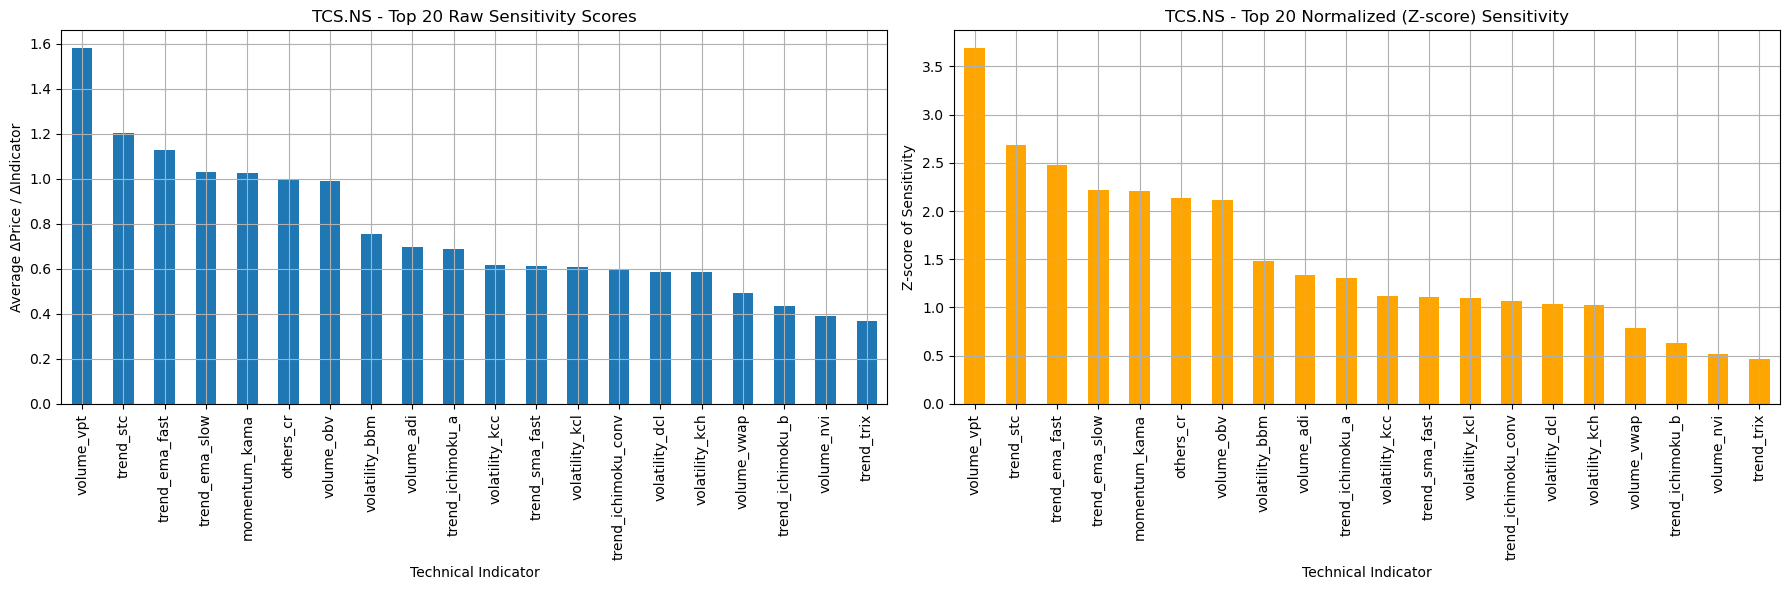


📌 Top 20 Indicators by Raw Average Sensitivity:
                     Average_Sensitivity
volume_vpt                      1.581118
trend_stc                       1.204721
trend_ema_fast                  1.127855
trend_ema_slow                  1.029316
momentum_kama                   1.027315
others_cr                       1.000000
volume_obv                      0.990740
volatility_bbm                  0.753622
volume_adi                      0.698456
trend_ichimoku_a                0.688995
volatility_kcc                  0.616762
trend_sma_fast                  0.611482
volatility_kcl                  0.609180
trend_ichimoku_conv             0.596827
volatility_dcl                  0.587596
volatility_kch                  0.583981
volume_vwap                     0.491734
trend_ichimoku_b                0.433837
volume_nvi                      0.391201
trend_trix                      0.370400

📌 Top 20 Indicators by Z-score Normalized Sensitivity:
                     Zscore_Sensit

In [2]:
sensitivity_df = sensitivity_analysis("TCS.NS", period=5)

📥 Downloading data for INFY.NS...


[*********************100%***********************]  1 of 1 completed
/Users/utsavdhanuka/miniconda3/envs/env_pytorch/lib/python3.9/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


🧠 Computing all technical indicators...


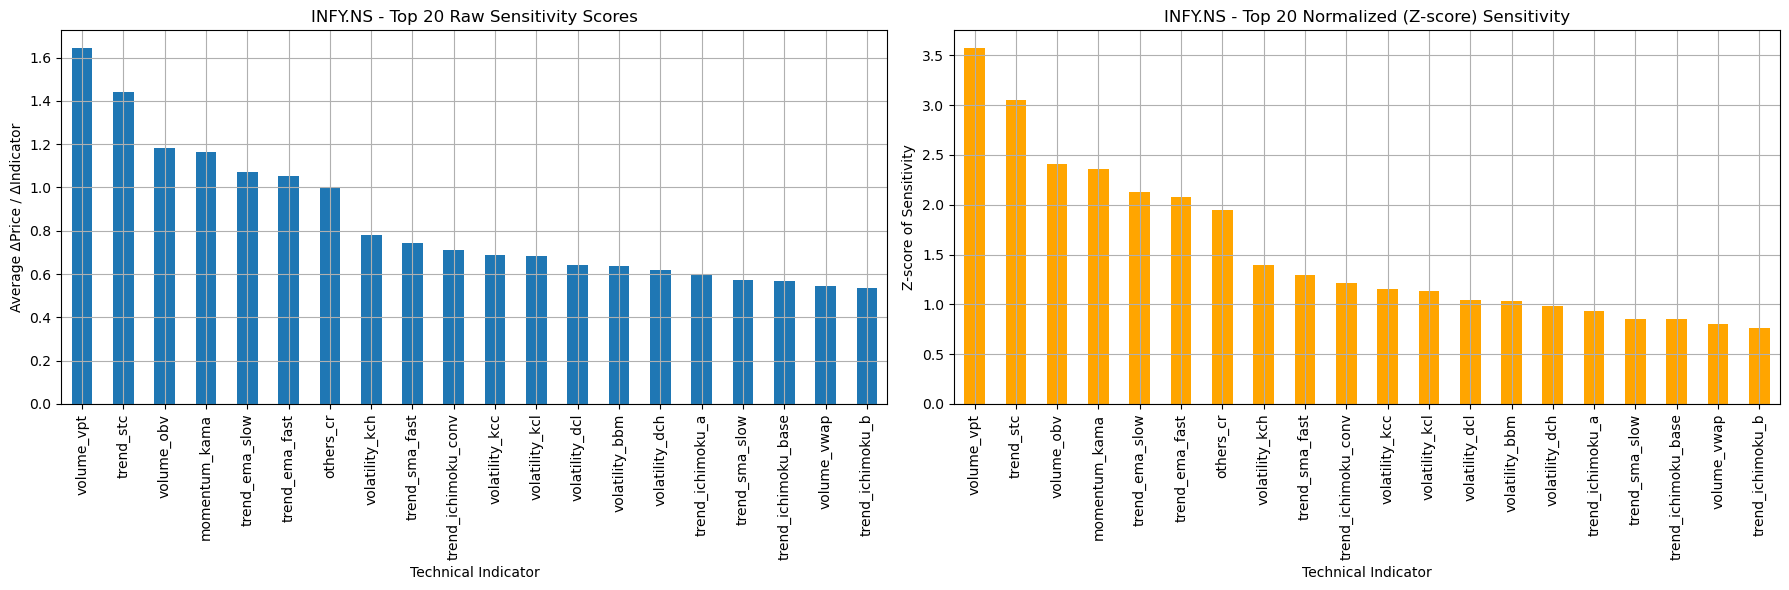


📌 Top 20 Indicators by Raw Average Sensitivity:
                     Average_Sensitivity
volume_vpt                      1.643880
trend_stc                       1.439625
volume_obv                      1.182490
momentum_kama                   1.162975
trend_ema_slow                  1.072085
trend_ema_fast                  1.053696
others_cr                       1.000000
volatility_kch                  0.781580
trend_sma_fast                  0.741251
trend_ichimoku_conv             0.712079
volatility_kcc                  0.685718
volatility_kcl                  0.681076
volatility_dcl                  0.643760
volatility_bbm                  0.638209
volatility_dch                  0.620688
trend_ichimoku_a                0.599110
trend_sma_slow                  0.570177
trend_ichimoku_base             0.567171
volume_vwap                     0.546547
trend_ichimoku_b                0.534334

📌 Top 20 Indicators by Z-score Normalized Sensitivity:
                     Zscore_Sensit

In [5]:
sensitivity_df = sensitivity_analysis("INFY.NS", period=5)

📥 Downloading data for WIPRO.NS...


[*********************100%***********************]  1 of 1 completed


🧠 Computing all technical indicators...


/Users/utsavdhanuka/miniconda3/envs/env_pytorch/lib/python3.9/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


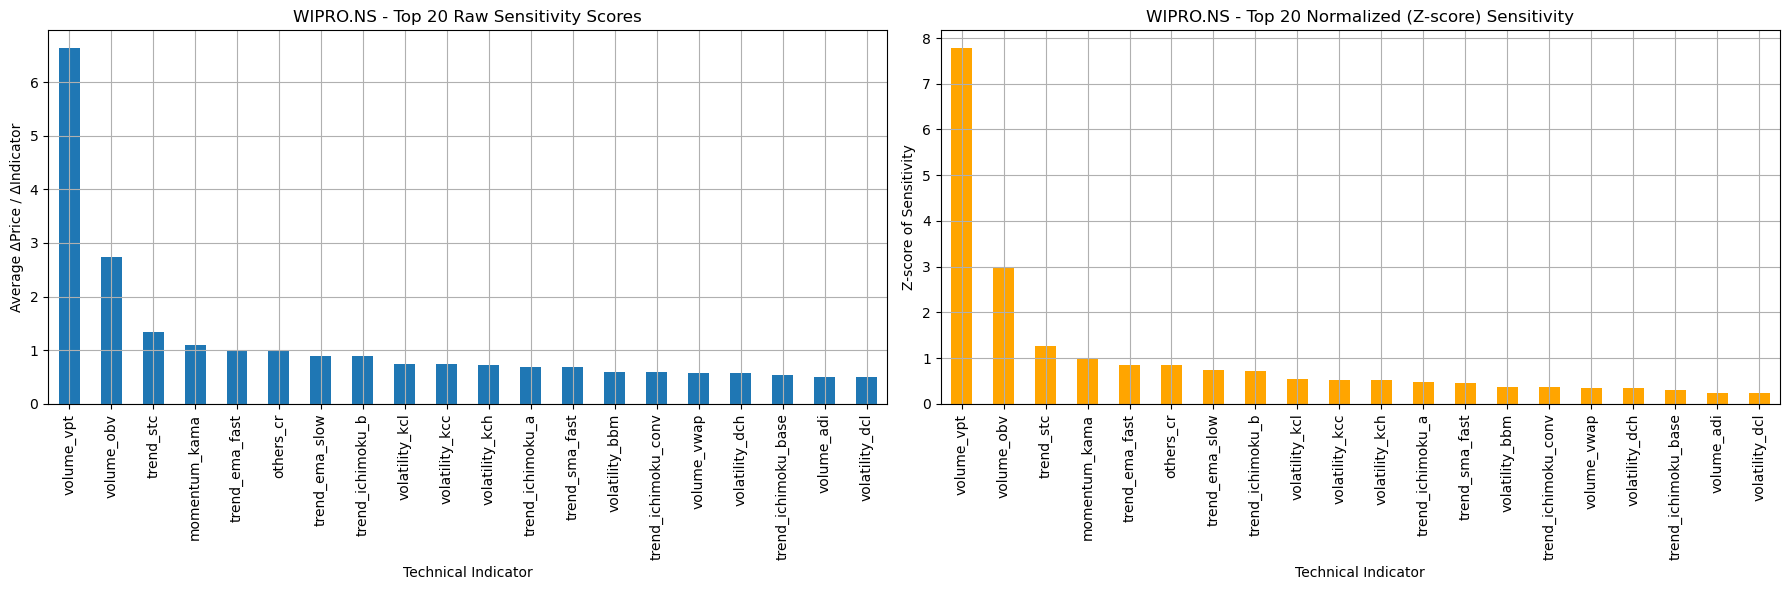


📌 Top 20 Indicators by Raw Average Sensitivity:
                     Average_Sensitivity
volume_vpt                      6.634137
volume_obv                      2.734983
trend_stc                       1.335402
momentum_kama                   1.098446
trend_ema_fast                  1.000963
others_cr                       1.000000
trend_ema_slow                  0.899536
trend_ichimoku_b                0.891623
volatility_kcl                  0.752024
volatility_kcc                  0.737916
volatility_kch                  0.722030
trend_ichimoku_a                0.690605
trend_sma_fast                  0.682010
volatility_bbm                  0.601606
trend_ichimoku_conv             0.600260
volume_vwap                     0.581027
volatility_dch                  0.578713
trend_ichimoku_base             0.545931
volume_adi                      0.502726
volatility_dcl                  0.499004

📌 Top 20 Indicators by Z-score Normalized Sensitivity:
                     Zscore_Sensit

In [6]:
sensitivity_df = sensitivity_analysis("WIPRO.NS", period=5)